## AutoEncoder
- 사람의 지도 없이 학습하는 오토인코더
- 오토인코더는 레이블이 없이 특징을 추출하는 신경망이며 입력값만으로 학습을 함
- 특정 데이터를 효율적으로 나타내기 위해 고차원을 저차원으로 차원 축소하는 방법
- 비지도학습 신경망 오토인코더로 잡음을 제거하여 데이터를 복원하기

### Keywords
- Unsupervised learning
- Nonlinear Dimensionality reduction
    - Representation learning
    - Efficient coding learning
    - Feature extraction
    - Manifold learning
- Generative model learning
- ML Density estimation

### 모델 종류
- AE (Auto Encoder)
- DAE (Denoising AE)
- CAE (Contractive AE)

- Variational Autoencoders
    - VAE (Variational AE)
    - CVAE (Conditional VAE)
    - AAE (Adversarial AE)

### 오토인코더의 학습
- 학습시
    - 학습방법은 비교사 학습 방법 (unsupervised learning)
    - Loss는 negative ML로 해석 (ML Density estimation)
- 학습된 오토인코더
    - 인코더는 차원 축소 역할 수행 (Manifold learning)
    - 디코더는 생성 모델의 역할 수행 (Generative model learning)

### 오토인코더 구조
-  MLP(Multi-Layer Perceptron)와 유사한 구조, but 입력층과 출력층의 뉴런 수가 동일
- 중간으로 갈수록 신경망의 차원이 줄어듬. (정보를 압축한다)
    - 정보의 통로가 줄어들고 병목현상이 일어나 입력의 특징들이 '압축'되도록 학습
    - 정보의 구성에 우선순위가 있다는 뜻 (인물사진의 배경색은 중요한 요소가 아니며, 정보에서 덜 중요한 요소를 버리는 과정이 압축이라고도 할 수 있음)

- 잠재변수(작은 차원에 압축된 표현, = z, latent variable)
    - 잠재변수(latent varaiable)를 기준으로 앞부분이 인코더, 뒷부분이 디코더

### 정보손실
- 오토인코더는 필연적으로 정보의 손실이 발생
- 원본 데이터의 디테일을 잃어버린다는 뜻 = 중요한 정보만 남겨두는 데이터 가공의 일종이기도 함

### 오토인코더 활용
- 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄여주는 용도로 사용
- 비정상 거래 검출, 데이터 시각화와 복원, 의미 추출, 이미지 검색 등 사용

### 참고문헌
- https://www.slideshare.net/NaverEngineering/ss-96581209 // 오토인코더의 모든 것 slide share

![autoencoder.jpg](readme_image/autoencoder.jpg)

## 오토인코더로 이미지의 특징을 추출하기

In [33]:
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 오토인코더 생성하는 이미지 관찰을 위한 matplotlib, numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼 파라미터
epochs = 3
batch_size = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [19]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

In [29]:
## 오토인코더 모듈 정의

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # self.encoder, self.decoder 정의 및 nn.sequential()을 이용한 묶기
        # encoder - FC-FC-FC
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # 3개여의 특징만 남긴다. (입력의 특징을 3차원 압축)
        )
        
        # decoder - FC-FC-FC 채널 역순
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # 3개여의 특징만 남긴다.
            nn.Sigmoid(), # 마지막 출력값을 0~1사이로 만들어주는 nn.Sigmoid() 함수가 더해진 것
        )
        
    # Forward
    def forward(self, x):
        encoded = self.encoder(x) # encoder 생성
        decoded = self.decoder(encoded) # encoder 바탕으로 decoder 

        return encoded, decoded # 복원 이미지

In [30]:
# 학습 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    # step 마다 train_loader 에서 데이터를 불러옴.
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE) # 입력값도 X 
        y = x.view(-1, 28*28).to(DEVICE) # 결과값도 X
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        # loss 계산, 미분 및 역전파, 반복
        loss = criterion(decoded, y)
        optimizer.zero_grad() # 오차에 대해 미분
        loss.backward() # 역전파 진행
        optimizer.step() # 

[Epoch 1]


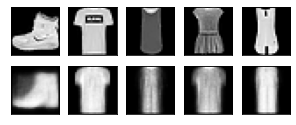

[Epoch 2]


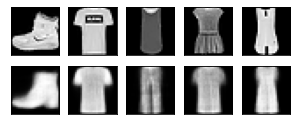

[Epoch 3]


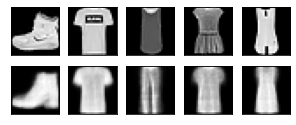

In [34]:

# 모델 옵션 설정 및 학습
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) # 최적화 모듈 Adam
criterion = nn.MSELoss() # 두 행렬간의 차이제곱

# 원본 이미지 
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습 진행
for epoch in range(1, epochs+1):
    train(autoencoder, train_loader)
    
    # 디코더에서 나온 이미지를 시각화하기
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 비교해보기 - subplot 에 출력
    f, a = plt.subplots(2, 5, figsize = (5,2))
    print("[Epoch {}]".format(epoch))

    # matplotlib 는 pytorch tensor를 지원하지 않기 때문에 numpy() 로 다시 수정해주어야 함.
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28,28))
        a[0][i].imshow(img, cmap='gray') # Fashion MNIST 와 같은 Color map => gray
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()
